# Objective Functions: A Simple Example with Matrix Factorisation.

### Modified by Mauricio A Álvarez, October 2018, 2019

### 6th October 2015 Neil D. Lawrence

In last week's class we saw how we could load in a data set to pandas and use it for some simple data processing. We computed various probabilities on the data and I encouraged you to think about what sort of probabilities you need for prediction. This week we are going to take a slightly different tack. 

Broadly speaking there are two dominating approaches to machine learning problems. We started to consider the first approach last week: constructing models based on defining the relationship between variables using probabilities. This week we will consider the second approach: which involves defining an *objective function* and optimizing it. 

確率を使用した変数間の関係の定義に基づいたモデルの構築 or 目的関数の定義と最適化

What do we mean by an objective function? An objective function could be an *error function*, a *cost function* or a *benefit* function. In evolutionary computing they are called *fitness* functions. But the idea is always the same. We write down a mathematical equation which is then optimized to do the learning. The equation should be a function of the *data* and our model *parameters*. We have a choice when optimizing, either minimize or maximize. To avoid confusion, in the optimization field, we always choose to minimize the function. If we have a function that we would like to maximize, we simply choose to minimize the negative of that function. 

So for this lab session, we are going to ignore probabilities, but don't worry, they will return! 

This week we are going to try and build a simple movie recommender system using an objective function. To do this, the first thing I'd like you to do is to install some software we've written for sharing information across google documents.

## Open Data Science Software

In Sheffield we have written a suite of software tools for 'Open Data Science'. Open data science is an approach to sharing code, models and data that should make it easier for companies, health professionals and scientists to gain access to data science techniques. For some background on open data science you can read [this blog post](http://inverseprobability.com/2014/07/01/open-data-science/). The first thing we will do this week is to download that suite of software. 

The software can be installed using

```python
pip install pods
```

from the command prompt where you can access your python installation.


## Download the MovieLens 100k Data

We are going to download the [MovieLens 100k](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html) Data. This is a public dataset that contains 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. When you use a data set that someone has prepared you should always reference the data source to acknowledge the work that's been placed in. This particular dataset was collected by the [Grouplens Research group](https://grouplens.org/),  at the University of Minnesota. For example, if you were to use this dataset for writing a paper, the authors ask you that you acknowledge their work by citing the following paper:

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5 (4):1-19 [https://doi.org/10.1145/2827872](https://doi.org/10.1145/2827872)

In [1]:
import pods
import zipfile
import sys
import pandas as pd
import numpy as np

/Users/Atsuki/.pyenv/versions/3.6.2/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
pods.util.download_url("http://files.grouplens.org/datasets/movielens/ml-latest-small.zip")
zip_console = zipfile.ZipFile('ml-latest-small.zip', 'r')
for name in zip_console.namelist():
           zip_console.extract(name, './')

[==============================]   0.933/0.933MB                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

### Question 1

Data ethics. If you find data available on the internet, can you simply use it without consequence? If you are given data by a fellow researcher can you publish that data on line? 

#### Question 1 Answer

We have to check the license of the data before use it.

-----
It depends on the licensing terms of the data. However, if the data has no licensing terms but it is related to a person in someway (e.g. health data)then there may be consequences, depending on local laws.

In general no, you would certainly have to get their permission. Be very careful about data containing any personal information. Even data that is anonymized can be "de-anonymized".

## Recommender Systems

A recommender system aims to make suggestions for items (films, books, other commercial products) given what it knows about users' tastes. The recommendation engine needs to represent the *taste* of all the users and the *characteristics* of each object. 

A common way for organizing objects is to place related objects spatially close together. For example in a library we try and put books that are on related topics near to each other on the shelves. One system for doing this is known as [Dewey Decimal Classification](http://en.wikipedia.org/wiki/Dewey_Decimal_Classification). In the Dewey Decimal Classification system (which dates from 1876) each subject is given a number (in fact it's a decimal number). For example, the field of Natural Sciences and Mathematics is given numbers which start with 500. Subjects based on Computer Science are given numbers which start 004 and works on the 'mathematical principles' of Computer science are given the series 004.0151 (which we might store as 4.0151 on a Computer). Whilst it's a classification system, the books in the library are typically laid out in the same order as the numbers, so we might expect that neighbouring numbers represent books that are related in subject. That seems to be exactly what we want when also representing films. Could we somehow represent each film's subject according to a number? In a similar way we could then imagine representing users with a list of numbers that represent things that each user is interested in.

Actually a one dimensional representation of a subject can be very awkward. To see this, let's have a look at the Dewey Decimal Classification numbers for the 900s, which is listed as 'History and Geography'. We will focus on subjects in the 940s which can be found in this list from [Wikipedia](https://en.wikipedia.org/wiki/List_of_Dewey_Decimal_classes#Class_900_%E2%80%93_History_&_geography). Whilst the ordering for places is somewhat sensible, it is also rather arbitrary. In the 940s we have Europe listed from 940-949, Asia listed from 950-959 and Africa listed from 960-969. Whilst it's true that Asia borders Europe, Africa is also very close, and the history of the Roman Empire spreads into [Carthage](http://en.wikipedia.org/wiki/Carthage) and later on Egypt. This image from Wikipedia shows a map of the Cathaginian Empire which fell after fighting with Rome. 


<a title="By Javierfv1212 [Public domain], from Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Carthaginianempire.PNG"><img width="512" alt="Carthaginianempire" src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9b/Carthaginianempire.PNG/512px-Carthaginianempire.PNG"></a>

We now need to make a decision about whether Roman Histories are European or African, ideally we'd like them to be somewhere between the two, but we can't place them there in the Dewey Decimal system because between Europe and Africa is Asia, which has less to do with the Roman Empire than either Europe or Africa. Of course the fact that we've used a map provides a clue as to what to do next. Libraries are actually laid out on floors, so what if we were to use the spatial lay out to organise the sujbects of the books in two dimensions. Books on Geography could be laid out according to where in the world they are referring to. 

Such complexities are very hard to encapsulate in one number, but inspired by the map examples we can start considering how we might lay out films in two dimensions. Similarly, we can consider laying out a map of people's interests. If the two maps correspond to one another, the map of people could reflect where they might want to live in 'subject space'. We can think of representing people's tastes as where they might best like to sit in the library to access easily the books they are most interested in.


## Inner Products for Representing Similarity

Ideas like the above are good for gaining intuitions about what we might want, but the one of the skills of data science is representing those ideas mathematically. Mathematical abstraction of a problem is one of the key ways in which we've been able to progress as a society. Understanding planetary motions, as well as those of the smallest molecule (to quote Laplace's [Philosophical Essay on Probabilities](http://books.google.co.uk/books?id=1YQPAAAAQAAJ&printsec=frontcover&source=gbs_ge_summary_r&cad=0#v=onepage&q&f=false)) needed to be done mathematically. The right mathematical model in machine learning can be slightly more elusive, because constructing it is a two stage process. 

1. We have to determine the right intuition for the system we want to represent. Notions such as 'subject' and 'interest' are not mathematically well defined, and even when we create a new interpretation of what they might mean, each interpretation may have its own weaknesses. 

2. Once we have our interpretation we can attempt to mathematically formalize it. In our library interpretation, that's what we need to do next. 

### The Library on an Infinite Plane

Let's imagine a library which stores all the items  we are interested in, not just books, but films and shopping items too. Such a library is likely to be very large, so we'll create it on an infinite two dimensional plane. This means we can use all the real numbers to represent the location of each item on the plane. For a two dimensional plane, we need to store the locations in a vector of numbers: we can decide that the $j$th item's location in the library is given by 
$$
\mathbf{v}_j = \begin{bmatrix} v_{j,1} \\ v_{j,2}\end{bmatrix},
$$
where $v_{j,1}$ represents the $j$th item's location in the East-West direction (or the $x$-axis) and $v_{j,2}$ represents the $j$th item's location in the North-South direction (or the $y$-axis). Now we need to specify the location where each user sits so that all the items that interest them are nearby: we can also represent the $i$th user's location with a vector 
$$
\mathbf{u}_i = \begin{bmatrix} u_{i,1} \\ u_{i,2}\end{bmatrix}.
$$
Finally, we need some way of recording a given user's affinity for a given item. This affinity might be the rating that the user gives the film. We can use $y_{i,j}$ to represent user $i$'s affinity for item $j$. 

For our film example we might imagine wanting to order films in a few ways. We could imagine organising films in the North-South direction as to how romantic they are. We could place the more romantic films further North and the less romantic films further South. For the East-West direction we could imagine ordering them according to how historic they are: we can imagine placing science fiction films to the East and historical drama to the West. In this case, fans of historical romances would be based in the North-West location, whilst fans of Science Fiction Action films might be located in the South-East (if we assume that 'Action' is the opposite of 'Romance', which is not necessarily the case). How do we lay out all these films? Have we got the right axes? In machine learning the answer is to 'let the data speak'. Use the data to try and obtain such a lay out. To do this we first need to obtain the data.

## Obtaining the Data

As mentioned before, the MovieLens dataset that we'll use has 100,000 ratings to 9,000 movies by 600 users. For now, we will only work with a subset of the dataset. In particular, we will randomly chose a particular number of users and extract the movies and ratings that the users gave to those movies. Read the code below and understand what it is doing.

**Before you run the code**, notice that `YourStudentID` in the first line is a variable that will specify the seed for the random number generator that will select a particular set of `nUsersInExample` users. Change the number that has been assigned by default to `YourStudentID` to the last three digits of your UCard number. All of you will have a different subset of users.

In [3]:
YourStudentID = 928  # Include here the last three digits of your UCard number
nUsersInExample = 10 # The maximum number of Users we're going to analyse at one time

ratings = pd.read_csv("./ml-latest-small/ratings.csv") 
"""
ratings is a DataFrame with four columns: userId, movieId, rating and tags. We
first want to identify how many unique users there are. We can use the unique 
method in pandas
"""
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [4]:
indexes_unique_users = ratings['userId'].unique()
print(indexes_unique_users)
n_users = indexes_unique_users.shape[0] # 610

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

In [5]:
""" 
We randomly select 'nUsers' users with their ratings. We first fix the seed
of the random generator to make sure that we always get the same 'nUsers'
"""
np.random.seed(YourStudentID)
indexes_users = np.random.permutation(n_users) # 配列をランダムに並び替え
print(indexes_users)

my_batch_users = indexes_users[0:nUsersInExample]
print(my_batch_users) # nUsers...: 10

[115 429 265 435 352 366   8 577 323  69 110  96 468 543  95 542 315 372
  39 107 434 201 457 318 175 109 241 425 549 258 569 594  76 482 211 218
 593 196 394 391 161 493 190 507 290 393 364 220 424 203 311 559 383 596
 243 178 301 247 325 150 454 152 284 583 420  15 123 172 256 288  68 592
 141 164 255 269 191 106 557 553  24 309 304 467 518 195  20 438 165  18
 100 463 607 513 378  45 225  81 283 212 322  12 409 600  19 370 224 500
 170 103   5 408 229 122 292  61 360 444 597 529 331   1 262 210 308  93
   4 294  91 350 413 133 508 194 297 581  48 202 397  33 139 399 419 277
 400 187 471 455  53 470 357  79 260 149 562  80 121 418 276 411 396 245
 582 436 517 544  63 578 498  13 533 354  73 472 519 484 274 334 336 427
 239 338 441 501  88 390 554 135 321 128 415 244  36 160 151 137 480 580
 402 496 546 491 375 595 473 329 130 267 105 575 186  32 112 380 209 228
 510 216 368 603 314 556 176  55 359 590 324 403   7 114 521 145 270 511
 490 206 222 447 219 410 605 374 461 339 574 516 27

In [14]:
"""
We will use now the list of 'my_batch_users' to create a matrix Y. 
"""
# We need to make a list of the movies that these users have watched
list_movies_each_user = [[] for _ in range(nUsersInExample)]
list_ratings_each_user = [[] for _ in range(nUsersInExample)]
# Movies
list_movies = ratings['movieId'][ratings['userId'] == my_batch_users[0]].values
print(ratings['movieId'])
print(my_batch_users[0])
print(ratings['movieId'][ratings['userId'] == my_batch_users[0]])
print(list_movies)
# 115番さんがみた映画のリスト


0              1
1              3
2              6
3             47
4             50
5             70
6            101
7            110
8            151
9            157
10           163
11           216
12           223
13           231
14           235
15           260
16           296
17           316
18           333
19           349
20           356
21           362
22           367
23           423
24           441
25           457
26           480
27           500
28           527
29           543
           ...  
100806    150401
100807    152077
100808    152081
100809    152372
100810    155064
100811    156371
100812    156726
100813    157296
100814    158238
100815    158721
100816    158872
100817    158956
100818    159093
100819    160080
100820    160341
100821    160527
100822    160571
100823    160836
100824    161582
100825    161634
100826    162350
100827    163937
100828    163981
100829    164179
100830    166528
100831    166534
100832    168248
100833    1682

In [16]:
list_movies_each_user[0] = list_movies                    
# Ratings                      
list_ratings = ratings['rating'][ratings['userId'] == my_batch_users[0]].values
list_ratings_each_user[0] = list_ratings

# Users
n_each_user = list_movies.shape[0]
print(n_each_user)
list_users = my_batch_users[0]*np.ones((1, n_each_user))
print(list_users.shape)

112
(1, 112)


In [17]:
for i in range(1, nUsersInExample):
    # Movies
    local_list_per_user_movies = ratings['movieId'][ratings['userId'] == my_batch_users[i]].values
    list_movies_each_user[i] = local_list_per_user_movies
    list_movies = np.append(list_movies,local_list_per_user_movies)
    # Ratings                                 
    local_list_per_user_ratings = ratings['rating'][ratings['userId'] == my_batch_users[i]].values
    list_ratings_each_user[i] = local_list_per_user_ratings
    list_ratings = np.append(list_ratings, local_list_per_user_ratings)  
    # Users                                   
    n_each_user = local_list_per_user_movies.shape[0]                                                                               
    local_rep_user =  my_batch_users[i]*np.ones((1, n_each_user))    
    list_users = np.append(list_users, local_rep_user)

In [19]:
# Let us first see how many unique movies have been rated
indexes_unique_movies = np.unique(list_movies)
print(indexes_unique_movies)
n_movies = indexes_unique_movies.shape[0]

[     1      2      6     10     11     17     19     21     22     25
     29     32     34     36     39     47     48     50     60     62
     79     88    105    110    111    112    141    150    151    153
    158    161    163    164    165    168    169    172    173    185
    186    195    196    203    204    207    208    216    218    222
    225    227    230    231    234    235    236    237    252    253
    256    257    260    261    266    270    272    273    274    276
    279    281    282    289    292    294    296    300    315    316
    317    318    327    329    333    337    339    342    343    348
    349    351    356    357    361    364    367    368    370    376
    377    379    380    381    383    388    410    420    421    432
    434    435    436    440    454    457    468    474    475    480
    485    487    491    494    497    500    508    509    516    524
    527    529    531    534    539    541    551    553    562    586
    58

In [20]:
# As it is expected no all users have rated all movies. We will build a matrix Y 
# with NaN inputs and fill according to the data for each user 
temp = np.empty((n_movies,nUsersInExample,))
temp[:] = np.nan
Y_with_NaNs = pd.DataFrame(temp)
for i in range(nUsersInExample):
 local_movies = list_movies_each_user[i]
 ixs = np.in1d(indexes_unique_movies, local_movies) # 1番目の引数の配列の各要素が、2番目の引数の配列に含まれるかどうかの真偽値を返す。
 Y_with_NaNs.loc[ixs, i] = list_ratings_each_user[i]

Y_with_NaNs.index = indexes_unique_movies.tolist()
Y_with_NaNs.columns = my_batch_users.tolist()

### Question 2

Have a look at the matrix `Y_with_NaNs`. The movies data is now in a data frame which contains one column for each user rating the movie. There are some entries that contain 'NaN'. What does the 'NaN' mean in this context?

In [21]:
print(Y_with_NaNs)

        115  429  265  435  352  366  8    577  323  69 
1       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  3.5  NaN
2       NaN  NaN  NaN  NaN  NaN  NaN  4.0  NaN  4.0  NaN
6       NaN  NaN  NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN
10      NaN  NaN  NaN  NaN  NaN  NaN  2.0  NaN  NaN  NaN
11      NaN  NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN
17      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  3.5  NaN
19      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  2.5  NaN
21      4.0  NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN
22      NaN  4.0  NaN  NaN  NaN  NaN  NaN  NaN  3.0  NaN
25      NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN
29      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  3.5  NaN
32      5.0  NaN  4.0  NaN  NaN  NaN  3.0  NaN  2.5  NaN
34      2.0  NaN  NaN  NaN  NaN  NaN  5.0  NaN  2.5  NaN
36      NaN  NaN  4.0  NaN  NaN  NaN  NaN  NaN  3.5  NaN
39      NaN  NaN  NaN  NaN  NaN  NaN  3.0  3.0  NaN  NaN
47      NaN  NaN  NaN  NaN  5.0  NaN  4.0  NaN  NaN  NaN
48      NaN  4.0  NaN  4.0  NaN

#### Answer Question 2

NaN: not a number: A user did not watch a specific movie.

-----
In this context, NaN represents a movie that has not been given a rating by the user of that column.

Write your answer to the question in this box.

Now we will convert our data structure into a form that is appropriate for processing. We will convert the `Y_with_NaNs` dataframe into a new dataframe which contains the user, the movie, and the rating using the following code

In [27]:
print(list_ratings_each_user)

[array([4., 5., 2., 3., 2., 3., 4., 5., 5., 4., 4., 4., 1., 2., 4., 5., 5.,
       5., 4., 5., 3., 5., 5., 3., 4., 2., 1., 2., 4., 5., 4., 5., 5., 5.,
       5., 1., 5., 5., 2., 1., 5., 5., 2., 5., 2., 5., 4., 5., 3., 4., 4.,
       4., 4., 4., 3., 5., 5., 3., 2., 5., 4., 4., 4., 4., 3., 3., 5., 2.,
       3., 4., 3., 4., 2., 4., 2., 3., 4., 3., 3., 1., 5., 5., 4., 1., 4.,
       3., 5., 4., 5., 3., 5., 3., 3., 5., 4., 4., 4., 4., 4., 3., 5., 5.,
       5., 5., 4., 5., 3., 3., 4., 4., 4., 5.]), array([4., 4., 4., 5., 4., 5., 3., 4., 5., 3., 5., 4., 4., 4., 5., 3., 4.,
       4., 4., 3., 2., 4., 4., 5., 4., 4., 5., 4., 5., 4., 3., 3., 4., 4.,
       5., 5., 3., 4., 4., 3., 5., 3., 5., 3., 3., 4., 5., 4., 2., 4., 3.,
       4., 3., 3., 5., 5., 5., 5.]), array([1., 4., 4., 2., 3., 3., 4., 2., 4., 3., 5., 3., 3., 4., 5., 4., 4.,
       4., 4., 2., 2., 4., 3., 3., 3., 4., 3., 4., 4., 4., 3., 3., 5., 4.,
       2., 4., 3., 3., 4., 4., 5., 5., 3., 3., 3., 4., 3., 3., 5., 5., 4.,
       2., 4.

In [32]:
p_list_ratings = np.concatenate(list_ratings_each_user).ravel() # ravel関数は、多次元のリストを1次元のリストにして返します。
p_list_ratings_original = p_list_ratings.tolist()
mean_ratings_train = np.mean(p_list_ratings)
p_list_ratings =  p_list_ratings - mean_ratings_train # remove the mean

####################
p_list_movies = np.concatenate(list_movies_each_user).ravel().tolist()

####################
p_list_users = list_users.tolist()

####################
Y = pd.DataFrame({'users': p_list_users, 'movies': p_list_movies, 'ratingsorig': p_list_ratings_original,'ratings':p_list_ratings.tolist()})

print(Y)

[4. 5. 2. ... 3. 5. 3.]
      movies   ratings  ratingsorig  users
0         21  0.322719          4.0  115.0
1         32  1.322719          5.0  115.0
2         34 -1.677281          2.0  115.0
3        110 -0.677281          3.0  115.0
4        112 -1.677281          2.0  115.0
5        153 -0.677281          3.0  115.0
6        196  0.322719          4.0  115.0
7        260  1.322719          5.0  115.0
8        296  1.322719          5.0  115.0
9        364  0.322719          4.0  115.0
10       368  0.322719          4.0  115.0
11       370  0.322719          4.0  115.0
12       380 -2.677281          1.0  115.0
13       383 -1.677281          2.0  115.0
14       457  0.322719          4.0  115.0
15       480  1.322719          5.0  115.0
16       487  1.322719          5.0  115.0
17       553  1.322719          5.0  115.0
18       588  0.322719          4.0  115.0
19       589  1.322719          5.0  115.0
20       590 -0.677281          3.0  115.0
21       592  1.322719        

### Question 3

The dataframes `Y_with_NaNs` and `Y` contain the same information but organised in a different way. Explain what is the difference. We have also included two columns for ratings in dataframe `Y`, `ratingsorig` and `ratings`. Explain
the difference. 

#### Question 3 Answer

Y_with_NaNs have some missing values in the dataframe, while Y does not have those values. It is easier to refer to the specific movieid in Y_with_NaNs, but we have to care about missing values.

Because it is not easy to compare ratings compare movies in general, subtracting the value of mean from each value enables us to know what to extent each movie was good or not. Less computational cost.

-----
The dataframe Y_with_NaNs is organised as a matrix, with rows being movies and columns being users. The dataframe Y takes this information and makes each entry in Y_with_NaNs it's own row with the first column being the user, the next the movie, the next the original rating and the last the transformed rating. In mathematical terms, Y_with_NaNs is a matrix with the ijth entry representing the rating X of the ith movie for the jth user and the Y is a dataframe with columns, j i X. Thus Y_with_NaNs is movie-orientation while Y is user-orientation.

The ratingsorig is the raw rating given by a user, ratings is the original rating with the mean rating subtracted.

Write your answer to the question in this box.

## Measuring Similarity

We now need a measure for determining the similarity between the item and the user: how close the user is sitting to the item in the room if you like. We are going to use the inner product between the vector representing the item and the vector representing the user. 

An inner product (or [dot product](http://en.wikipedia.org/wiki/Dot_product)) between two vectors $\mathbf{a}$ and $\mathbf{b}$ is written as $\mathbf{a}\cdot\mathbf{b}$. Or in vector notation we sometimes write it as $\mathbf{a}^\top\mathbf{b}$. An inner product is simply the sum of the products of each element of the vector,
$$
\mathbf{a}^\top\mathbf{b} = \sum_{i} a_i b_i
$$
The inner product can be seen as a measure of similarity. The inner product gives us the cosine of the angle between the two vectors multiplied by their length. The smaller the angle between two vectors the larger the inner product. 
$$
\mathbf{a}^\top\mathbf{b} = |\mathbf{a}||\mathbf{b}| \cos(\theta)
$$
where $\theta$ is the angle between two vectors and $|\mathbf{a}|$ and $|\mathbf{b}|$ are the respective lengths of the two vectors.

Since we want each user to be sitting near each item, then we want the inner product to be large for any two items which are rated highly by that user. We can do this by trying to force the inner product $\mathbf{u}_i^\top\mathbf{v}_j$ to be similar to the rating given by the user, $y_{i,j}$. To ensure this we will use a least squares objective function for all user ratings.

## Objective Function

もっともらしいフィッティングの直線式のy方向のずれと座標のずれは，|y-f(x)|で表されて，それを最小化するには，二乗誤差をとる．

The error function (or objective function, or cost function) we will choose is known as 'sum of squares', we will aim to minimize the sum of squared squared error between the inner product of $\mathbf{u}_i$ and $\mathbf{v}_i$ and the observed score for the user/item pairing, given by $y_{i, j}$. 

The total objective function can be written as
$$
E(\mathbf{U}, \mathbf{V}) = \sum_{i,j} s_{i,j} (y_{i,j} - \mathbf{u}_i^\top \mathbf{v}_j)^2
$$
where $s_{i,j}$ is an *indicator* variable that is 1 if user $i$ has rated item $j$ and is zero otherwise. Here $\mathbf{U}$ is the matrix made up of all the vectors $\mathbf{u}$,
$$
\mathbf{U} = \begin{bmatrix} \mathbf{u}_1 \dots \mathbf{u}_n\end{bmatrix}^\top
$$
where we note that $i$th *row* of $\mathbf{U}$ contains the vector associated with the $i$th user and $n$ is the total number of users. This form of matrix is known as a *design matrix*. Similarly, we define the matrix
$$
\mathbf{V} = \begin{bmatrix} \mathbf{v}_1 \dots \mathbf{v}_m\end{bmatrix}^\top
$$
where again the $j$th row of $\mathbf{V}$ contains the vector associated with the $j$th item and $m$ is the total number of items in the data set.

## Objective Optimization

### with Gradient Descent

The idea is to mimimize this objective. A standard, simple, technique for minimizing an objective is *gradient descent* or *steepest descent*. In gradient descent we simply choose to update each parameter in the model by subtracting a multiple of the objective function's gradient with respect to the parameters. So for a parameter $u_{i,j}$ from the matrix $\mathbf{U}$ we would have an update as follows:
$$
u_{k,\ell} \leftarrow u_{k,\ell} - \eta \frac{\text{d} E(\mathbf{U}, \mathbf{V})}{\text{d}u_{k,\ell}} 
$$
where $\eta$ (which is pronounced *eta* in English) is a Greek letter representing the *learning rate*.  

We can compute the gradient of the objective function with respect to $u_{k,\ell}$ as
$$
\frac{\text{d}E(\mathbf{U}, \mathbf{V})}{\text{d}u_{k,\ell}} = -2 \sum_j s_{k,j}v_{j,\ell}(y_{k, j} - \mathbf{u}_k^\top\mathbf{v}_{j}). 
$$
Similarly each parameter $v_{i,j}$ needs to be updated according to its gradient. 


### Question 4

What is the gradient of the objective function with respect to $v_{k, \ell}$? Write your answer in the box below, and explain which differentiation techniques you used to get there. 

#### Question 4 Answer

$$
\frac{\text{d}E(\mathbf{U}, \mathbf{V})}{\text{d}v_{k,\ell}} = -2 \sum_i s_{k,j}u_{j,\ell}(y_{k, j} - \mathbf{u}_k^\top\mathbf{v}_{j}). 
$$

Write your answer to the question in this box.

-----
Initially we have 
$$
E(\mathbf{U}, \mathbf{V}) = \sum_{i,j} s_{i,j} (y_{i,j} - \mathbf{u}_i^\top \mathbf{v}_j)^2
$$
In order to find $ \frac{\text{d}E(\mathbf{U}, \mathbf{V})}{\text{d}v_{k,\ell}}$ we first have to use the product rule as there are 2 distinct functions however as $s_{i,j}$ is a constant, the first one equals zero and so we are left with 
$$
\frac{\text{d}E(\mathbf{U}, \mathbf{V})}{\text{d}v_{k,\ell}} = \sum_{i,j} s_{i,j} \times 
\frac{\text{d}(y_{i, j} - \mathbf{u}_i^\top\mathbf{v}_{j})^2}{\text{d}v_{k,\ell}}
$$
Next we have to perform $\frac{\text{d}(y_{i, j} - \mathbf{u}_i^\top\mathbf{v}_{j})^2}{\text{d}v_{k,\ell}}$ which is done using the chain rule. This gives 
$$
\frac{\text{d}(y_{i, j} - \mathbf{u}_i^\top\mathbf{v}_{j})^2}{\text{d}v_{k,\ell}} = 
2(y_{i, j} - \mathbf{u}_i^\top\mathbf{v}_{j}) \times \frac{-\text{d}\mathbf{u}_i^\top\mathbf{v}_{j}}{\text{d}v_{k,j}}
$$
Now, $\frac{\text{d}\mathbf{u}_i^\top\mathbf{v}_{j}}{\text{d}v_{k,\ell}}$ needs to be differentated. $\mathbf{u}_i^\top\mathbf{v}_{j}$ is the inner product of the vector $\mathbf{u}_i$ and  $\mathbf{v}_{j}$ and so is a sum of products. The only time this will not differentiate to zero is when one of the products in the sum contains $\mathbf{v}_{k,\ell}$, all other terms differentiate to zero. This means that the only inner products that do not differentiate to zero are those that involve $\mathbf{v}_k$. These products differentiate to $u_{i,\ell}$. This gives that:
$$
\frac{\text{d}\mathbf{u}_i^\top\mathbf{v}_{k}}{\text{d}v_{k,\ell}} = u_{i,\ell}
$$
The implications in the full equation is that $j=k$ and so the sum over $j$ now disappears as these other sums are all zero.
And so, putting all this working together gives the final result as:
$$
\frac{\text{d}E(\mathbf{U}, \mathbf{V})}{\text{d}v_{k,\ell}} = -2 \sum_i s_{i,k}u_{i,\ell}(y_{i, k} - \mathbf{u}_i^\top\mathbf{v}_{k}). 
$$

In [13]:
# Question 4 Code Answer

## Steepest Descent Algorithm

In the steepest descent algorithm we aim to minimize the objective function by subtacting the gradient of the objective function from the parameters. 

### Initialisation

To start with though, we need initial values for the matrix $\mathbf{U}$ and the matrix $\mathbf{V}$. Let's create them as `pandas` data frames and initialise them randomly with small values.

In [34]:
q = 2 # the dimension of our map of the 'library'
learn_rate = 0.01
U = pd.DataFrame(np.random.normal(size=(nUsersInExample, q))*0.001, index=my_batch_users)
print(U)
V = pd.DataFrame(np.random.normal(size=(n_movies, q))*0.001, index=indexes_unique_movies)
print(V)

            0         1
115  0.000428 -0.000550
429  0.000666  0.000926
265 -0.000534  0.000773
435 -0.000635 -0.000330
352  0.000056  0.001350
366  0.000260  0.000935
8   -0.000249 -0.000917
577 -0.000136  0.000386
323 -0.001700 -0.001332
69  -0.001343  0.001490
               0         1
1       0.001828  0.000719
2      -0.000449  0.000793
6       0.000148 -0.000580
10      0.000096  0.000163
11     -0.002171 -0.000566
17      0.001867  0.001160
19      0.000682 -0.000836
21      0.000423 -0.000180
22      0.001837  0.000448
25     -0.000937 -0.000643
29     -0.000601 -0.000811
32      0.000056 -0.000868
34     -0.000035  0.000228
36     -0.000215 -0.000701
39     -0.000007  0.000329
47     -0.000222  0.000183
48     -0.001150 -0.000203
50      0.000275 -0.000475
60     -0.000144 -0.000211
62     -0.000060 -0.000117
79      0.000237 -0.000230
88      0.000779 -0.001058
105     0.001040  0.000328
110    -0.000264 -0.000897
111    -0.000323 -0.000101
112    -0.000698 -0.000617
141    

Now that we have the initial values set, we can start the optimization. First we define a function for the gradient of the objective and the objective function itself.

In [38]:
def objective_gradient(Y, U, V):
    gU = pd.DataFrame(np.zeros((U.shape)), index=U.index)
    gV = pd.DataFrame(np.zeros((V.shape)), index=V.index)
    obj = 0.
    nrows = Y.shape[0]
    for i in range(nrows):
        row = Y.iloc[i]
        user = row['users']
        film = row['movies']
        rating = row['ratings']
        print(U.loc[user])
        prediction = np.dot(U.loc[user], V.loc[film]) # vTu
        diff = prediction - rating # vTu - y
        obj += diff*diff
        gU.loc[user] += 2*diff*V.loc[film]
        gV.loc[film] += 2*diff*U.loc[user]
    return obj, gU, gV

Now we can write our simple optimisation route. This allows us to observe the objective function as the optimization proceeds.

In [39]:
iterations = 20
for i in range(iterations):
    obj, gU, gV = objective_gradient(Y, U, V)
    print("Iteration", i, "Objective function: ", obj)
    U -= learn_rate*gU
    V -= learn_rate*gV    

0   -0.074543
1   -0.065650
Name: 115, dtype: float64
0   -0.074543
1   -0.065650
Name: 115, dtype: float64
0   -0.074543
1   -0.065650
Name: 115, dtype: float64
0   -0.074543
1   -0.065650
Name: 115, dtype: float64
0   -0.074543
1   -0.065650
Name: 115, dtype: float64
0   -0.074543
1   -0.065650
Name: 115, dtype: float64
0   -0.074543
1   -0.065650
Name: 115, dtype: float64
0   -0.074543
1   -0.065650
Name: 115, dtype: float64
0   -0.074543
1   -0.065650
Name: 115, dtype: float64
0   -0.074543
1   -0.065650
Name: 115, dtype: float64
0   -0.074543
1   -0.065650
Name: 115, dtype: float64
0   -0.074543
1   -0.065650
Name: 115, dtype: float64
0   -0.074543
1   -0.065650
Name: 115, dtype: float64
0   -0.074543
1   -0.065650
Name: 115, dtype: float64
0   -0.074543
1   -0.065650
Name: 115, dtype: float64
0   -0.074543
1   -0.065650
Name: 115, dtype: float64
0   -0.074543
1   -0.065650
Name: 115, dtype: float64
0   -0.074543
1   -0.065650
Name: 115, dtype: float64
0   -0.074543
1   -0.065650


Name: 429, dtype: float64
0    0.00296
1    0.00158
Name: 429, dtype: float64
0    0.00296
1    0.00158
Name: 429, dtype: float64
0    0.00296
1    0.00158
Name: 429, dtype: float64
0    0.00296
1    0.00158
Name: 429, dtype: float64
0    0.00296
1    0.00158
Name: 429, dtype: float64
0    0.00296
1    0.00158
Name: 429, dtype: float64
0    0.00296
1    0.00158
Name: 429, dtype: float64
0    0.00296
1    0.00158
Name: 429, dtype: float64
0    0.00296
1    0.00158
Name: 429, dtype: float64
0    0.00296
1    0.00158
Name: 429, dtype: float64
0    0.00296
1    0.00158
Name: 429, dtype: float64
0    0.00296
1    0.00158
Name: 429, dtype: float64
0    0.00296
1    0.00158
Name: 429, dtype: float64
0    0.00296
1    0.00158
Name: 429, dtype: float64
0    0.00296
1    0.00158
Name: 429, dtype: float64
0   -0.056946
1    0.078455
Name: 265, dtype: float64
0   -0.056946
1    0.078455
Name: 265, dtype: float64
0   -0.056946
1    0.078455
Name: 265, dtype: float64
0   -0.056946
1    0.078455
Name

Name: 265, dtype: float64
0   -0.056946
1    0.078455
Name: 265, dtype: float64
0   -0.056946
1    0.078455
Name: 265, dtype: float64
0   -0.056946
1    0.078455
Name: 265, dtype: float64
0   -0.002134
1    0.009752
Name: 435, dtype: float64
0   -0.002134
1    0.009752
Name: 435, dtype: float64
0   -0.002134
1    0.009752
Name: 435, dtype: float64
0   -0.002134
1    0.009752
Name: 435, dtype: float64
0   -0.002134
1    0.009752
Name: 435, dtype: float64
0   -0.002134
1    0.009752
Name: 435, dtype: float64
0   -0.002134
1    0.009752
Name: 435, dtype: float64
0   -0.002134
1    0.009752
Name: 435, dtype: float64
0   -0.002134
1    0.009752
Name: 435, dtype: float64
0   -0.002134
1    0.009752
Name: 435, dtype: float64
0   -0.002134
1    0.009752
Name: 435, dtype: float64
0   -0.002134
1    0.009752
Name: 435, dtype: float64
0   -0.002134
1    0.009752
Name: 435, dtype: float64
0   -0.002134
1    0.009752
Name: 435, dtype: float64
0   -0.002134
1    0.009752
Name: 435, dtype: float64
0 

Name: 352, dtype: float64
0   -0.080665
1    0.223634
Name: 352, dtype: float64
0   -0.080665
1    0.223634
Name: 352, dtype: float64
0   -0.080665
1    0.223634
Name: 352, dtype: float64
0   -0.080665
1    0.223634
Name: 352, dtype: float64
0   -0.080665
1    0.223634
Name: 352, dtype: float64
0   -0.080665
1    0.223634
Name: 352, dtype: float64
0   -0.080665
1    0.223634
Name: 352, dtype: float64
0   -0.080665
1    0.223634
Name: 352, dtype: float64
0   -0.080665
1    0.223634
Name: 352, dtype: float64
0   -0.080665
1    0.223634
Name: 352, dtype: float64
0   -0.080665
1    0.223634
Name: 352, dtype: float64
0   -0.080665
1    0.223634
Name: 352, dtype: float64
0   -0.080665
1    0.223634
Name: 352, dtype: float64
0   -0.080665
1    0.223634
Name: 352, dtype: float64
0   -0.080665
1    0.223634
Name: 352, dtype: float64
0   -0.080665
1    0.223634
Name: 352, dtype: float64
0   -0.080665
1    0.223634
Name: 352, dtype: float64
0   -0.080665
1    0.223634
Name: 352, dtype: float64
0 

Name: 366, dtype: float64
0    0.000629
1    0.013069
Name: 366, dtype: float64
0   -0.010211
1    0.000623
Name: 8, dtype: float64
0   -0.010211
1    0.000623
Name: 8, dtype: float64
0   -0.010211
1    0.000623
Name: 8, dtype: float64
0   -0.010211
1    0.000623
Name: 8, dtype: float64
0   -0.010211
1    0.000623
Name: 8, dtype: float64
0   -0.010211
1    0.000623
Name: 8, dtype: float64
0   -0.010211
1    0.000623
Name: 8, dtype: float64
0   -0.010211
1    0.000623
Name: 8, dtype: float64
0   -0.010211
1    0.000623
Name: 8, dtype: float64
0   -0.010211
1    0.000623
Name: 8, dtype: float64
0   -0.010211
1    0.000623
Name: 8, dtype: float64
0   -0.010211
1    0.000623
Name: 8, dtype: float64
0   -0.010211
1    0.000623
Name: 8, dtype: float64
0   -0.010211
1    0.000623
Name: 8, dtype: float64
0   -0.010211
1    0.000623
Name: 8, dtype: float64
0   -0.010211
1    0.000623
Name: 8, dtype: float64
0   -0.010211
1    0.000623
Name: 8, dtype: float64
0   -0.010211
1    0.000623
Name: 8,

0   -0.057259
1    0.052547
Name: 577, dtype: float64
0   -0.057259
1    0.052547
Name: 577, dtype: float64
0   -0.057259
1    0.052547
Name: 577, dtype: float64
0   -0.057259
1    0.052547
Name: 577, dtype: float64
0   -0.057259
1    0.052547
Name: 577, dtype: float64
0   -0.057259
1    0.052547
Name: 577, dtype: float64
0   -0.057259
1    0.052547
Name: 577, dtype: float64
0   -0.057259
1    0.052547
Name: 577, dtype: float64
0   -0.057259
1    0.052547
Name: 577, dtype: float64
0   -0.057259
1    0.052547
Name: 577, dtype: float64
0   -0.057259
1    0.052547
Name: 577, dtype: float64
0   -0.057259
1    0.052547
Name: 577, dtype: float64
0   -0.057259
1    0.052547
Name: 577, dtype: float64
0   -0.057259
1    0.052547
Name: 577, dtype: float64
0   -0.057259
1    0.052547
Name: 577, dtype: float64
0   -0.057259
1    0.052547
Name: 577, dtype: float64
0   -0.057259
1    0.052547
Name: 577, dtype: float64
0   -0.057259
1    0.052547
Name: 577, dtype: float64
0   -0.057259
1    0.052547


Name: 69, dtype: float64
0   -0.018775
1    0.021990
Name: 69, dtype: float64
0   -0.018775
1    0.021990
Name: 69, dtype: float64
0   -0.018775
1    0.021990
Name: 69, dtype: float64
0   -0.018775
1    0.021990
Name: 69, dtype: float64
0   -0.018775
1    0.021990
Name: 69, dtype: float64
0   -0.018775
1    0.021990
Name: 69, dtype: float64
0   -0.018775
1    0.021990
Name: 69, dtype: float64
0   -0.018775
1    0.021990
Name: 69, dtype: float64
0   -0.018775
1    0.021990
Name: 69, dtype: float64
0   -0.018775
1    0.021990
Name: 69, dtype: float64
0   -0.018775
1    0.021990
Name: 69, dtype: float64
0   -0.018775
1    0.021990
Name: 69, dtype: float64
0   -0.018775
1    0.021990
Name: 69, dtype: float64
0   -0.018775
1    0.021990
Name: 69, dtype: float64
0   -0.018775
1    0.021990
Name: 69, dtype: float64
0   -0.018775
1    0.021990
Name: 69, dtype: float64
0   -0.018775
1    0.021990
Name: 69, dtype: float64
0   -0.018775
1    0.021990
Name: 69, dtype: float64
0   -0.018775
1    0.

Name: 429, dtype: float64
0    0.003407
1    0.002140
Name: 429, dtype: float64
0    0.003407
1    0.002140
Name: 429, dtype: float64
0    0.003407
1    0.002140
Name: 429, dtype: float64
0    0.003407
1    0.002140
Name: 429, dtype: float64
0    0.003407
1    0.002140
Name: 429, dtype: float64
0    0.003407
1    0.002140
Name: 429, dtype: float64
0    0.003407
1    0.002140
Name: 429, dtype: float64
0    0.003407
1    0.002140
Name: 429, dtype: float64
0    0.003407
1    0.002140
Name: 429, dtype: float64
0    0.003407
1    0.002140
Name: 429, dtype: float64
0    0.003407
1    0.002140
Name: 429, dtype: float64
0    0.003407
1    0.002140
Name: 429, dtype: float64
0    0.003407
1    0.002140
Name: 429, dtype: float64
0    0.003407
1    0.002140
Name: 429, dtype: float64
0    0.003407
1    0.002140
Name: 429, dtype: float64
0    0.003407
1    0.002140
Name: 429, dtype: float64
0    0.003407
1    0.002140
Name: 429, dtype: float64
0    0.003407
1    0.002140
Name: 429, dtype: float64
0 

Name: 435, dtype: float64
0   -0.003408
1    0.012822
Name: 435, dtype: float64
0   -0.003408
1    0.012822
Name: 435, dtype: float64
0   -0.003408
1    0.012822
Name: 435, dtype: float64
0   -0.003408
1    0.012822
Name: 435, dtype: float64
0   -0.003408
1    0.012822
Name: 435, dtype: float64
0   -0.003408
1    0.012822
Name: 435, dtype: float64
0   -0.003408
1    0.012822
Name: 435, dtype: float64
0   -0.003408
1    0.012822
Name: 435, dtype: float64
0   -0.003408
1    0.012822
Name: 435, dtype: float64
0   -0.003408
1    0.012822
Name: 435, dtype: float64
0   -0.003408
1    0.012822
Name: 435, dtype: float64
0   -0.003408
1    0.012822
Name: 435, dtype: float64
0   -0.003408
1    0.012822
Name: 435, dtype: float64
0   -0.003408
1    0.012822
Name: 435, dtype: float64
0   -0.003408
1    0.012822
Name: 435, dtype: float64
0   -0.003408
1    0.012822
Name: 435, dtype: float64
0   -0.003408
1    0.012822
Name: 435, dtype: float64
0   -0.105932
1    0.291654
Name: 352, dtype: float64
0 

Name: 352, dtype: float64
0   -0.105932
1    0.291654
Name: 352, dtype: float64
0   -0.105932
1    0.291654
Name: 352, dtype: float64
0   -0.105932
1    0.291654
Name: 352, dtype: float64
0   -0.105932
1    0.291654
Name: 352, dtype: float64
0   -0.105932
1    0.291654
Name: 352, dtype: float64
0   -0.105932
1    0.291654
Name: 352, dtype: float64
0   -0.105932
1    0.291654
Name: 352, dtype: float64
0   -0.105932
1    0.291654
Name: 352, dtype: float64
0   -0.105932
1    0.291654
Name: 352, dtype: float64
0   -0.105932
1    0.291654
Name: 352, dtype: float64
0   -0.105932
1    0.291654
Name: 352, dtype: float64
0   -0.105932
1    0.291654
Name: 352, dtype: float64
0   -0.105932
1    0.291654
Name: 352, dtype: float64
0   -0.105932
1    0.291654
Name: 352, dtype: float64
0   -0.105932
1    0.291654
Name: 352, dtype: float64
0   -0.105932
1    0.291654
Name: 352, dtype: float64
0   -0.105932
1    0.291654
Name: 352, dtype: float64
0   -0.105932
1    0.291654
Name: 352, dtype: float64
0 

0   -0.071692
1    0.065982
Name: 577, dtype: float64
0   -0.071692
1    0.065982
Name: 577, dtype: float64
0   -0.071692
1    0.065982
Name: 577, dtype: float64
0   -0.071692
1    0.065982
Name: 577, dtype: float64
0   -0.071692
1    0.065982
Name: 577, dtype: float64
0   -0.071692
1    0.065982
Name: 577, dtype: float64
0   -0.071692
1    0.065982
Name: 577, dtype: float64
0   -0.071692
1    0.065982
Name: 577, dtype: float64
0   -0.071692
1    0.065982
Name: 577, dtype: float64
0   -0.071692
1    0.065982
Name: 577, dtype: float64
0   -0.071692
1    0.065982
Name: 577, dtype: float64
0   -0.071692
1    0.065982
Name: 577, dtype: float64
0   -0.071692
1    0.065982
Name: 577, dtype: float64
0   -0.071692
1    0.065982
Name: 577, dtype: float64
0   -0.071692
1    0.065982
Name: 577, dtype: float64
0   -0.071692
1    0.065982
Name: 577, dtype: float64
0   -0.071692
1    0.065982
Name: 577, dtype: float64
0   -0.071692
1    0.065982
Name: 577, dtype: float64
0   -0.071692
1    0.065982


Name: 323, dtype: float64
0   -0.068058
1   -0.019671
Name: 323, dtype: float64
0   -0.068058
1   -0.019671
Name: 323, dtype: float64
0   -0.068058
1   -0.019671
Name: 323, dtype: float64
0   -0.068058
1   -0.019671
Name: 323, dtype: float64
0   -0.068058
1   -0.019671
Name: 323, dtype: float64
0   -0.068058
1   -0.019671
Name: 323, dtype: float64
0   -0.068058
1   -0.019671
Name: 323, dtype: float64
0   -0.068058
1   -0.019671
Name: 323, dtype: float64
0   -0.068058
1   -0.019671
Name: 323, dtype: float64
0   -0.068058
1   -0.019671
Name: 323, dtype: float64
0   -0.068058
1   -0.019671
Name: 323, dtype: float64
0   -0.068058
1   -0.019671
Name: 323, dtype: float64
0   -0.068058
1   -0.019671
Name: 323, dtype: float64
0   -0.068058
1   -0.019671
Name: 323, dtype: float64
0   -0.068058
1   -0.019671
Name: 323, dtype: float64
0   -0.068058
1   -0.019671
Name: 323, dtype: float64
0   -0.068058
1   -0.019671
Name: 323, dtype: float64
0   -0.068058
1   -0.019671
Name: 323, dtype: float64
0 

Name: 429, dtype: float64
0    0.003933
1    0.002891
Name: 429, dtype: float64
0    0.003933
1    0.002891
Name: 429, dtype: float64
0    0.003933
1    0.002891
Name: 429, dtype: float64
0    0.003933
1    0.002891
Name: 429, dtype: float64
0    0.003933
1    0.002891
Name: 429, dtype: float64
0    0.003933
1    0.002891
Name: 429, dtype: float64
0    0.003933
1    0.002891
Name: 429, dtype: float64
0    0.003933
1    0.002891
Name: 429, dtype: float64
0    0.003933
1    0.002891
Name: 429, dtype: float64
0    0.003933
1    0.002891
Name: 429, dtype: float64
0    0.003933
1    0.002891
Name: 429, dtype: float64
0    0.003933
1    0.002891
Name: 429, dtype: float64
0    0.003933
1    0.002891
Name: 429, dtype: float64
0    0.003933
1    0.002891
Name: 429, dtype: float64
0    0.003933
1    0.002891
Name: 429, dtype: float64
0    0.003933
1    0.002891
Name: 429, dtype: float64
0    0.003933
1    0.002891
Name: 429, dtype: float64
0    0.003933
1    0.002891
Name: 429, dtype: float64
0 

Name: 265, dtype: float64
0   -0.093523
1    0.122758
Name: 265, dtype: float64
0   -0.093523
1    0.122758
Name: 265, dtype: float64
0   -0.093523
1    0.122758
Name: 265, dtype: float64
0   -0.005133
1    0.016822
Name: 435, dtype: float64
0   -0.005133
1    0.016822
Name: 435, dtype: float64
0   -0.005133
1    0.016822
Name: 435, dtype: float64
0   -0.005133
1    0.016822
Name: 435, dtype: float64
0   -0.005133
1    0.016822
Name: 435, dtype: float64
0   -0.005133
1    0.016822
Name: 435, dtype: float64
0   -0.005133
1    0.016822
Name: 435, dtype: float64
0   -0.005133
1    0.016822
Name: 435, dtype: float64
0   -0.005133
1    0.016822
Name: 435, dtype: float64
0   -0.005133
1    0.016822
Name: 435, dtype: float64
0   -0.005133
1    0.016822
Name: 435, dtype: float64
0   -0.005133
1    0.016822
Name: 435, dtype: float64
0   -0.005133
1    0.016822
Name: 435, dtype: float64
0   -0.005133
1    0.016822
Name: 435, dtype: float64
0   -0.005133
1    0.016822
Name: 435, dtype: float64
0 

Name: 352, dtype: float64
0   -0.138971
1    0.380112
Name: 352, dtype: float64
0   -0.138971
1    0.380112
Name: 352, dtype: float64
0   -0.138971
1    0.380112
Name: 352, dtype: float64
0   -0.138971
1    0.380112
Name: 352, dtype: float64
0   -0.138971
1    0.380112
Name: 352, dtype: float64
0   -0.138971
1    0.380112
Name: 352, dtype: float64
0   -0.138971
1    0.380112
Name: 352, dtype: float64
0   -0.138971
1    0.380112
Name: 352, dtype: float64
0   -0.138971
1    0.380112
Name: 352, dtype: float64
0   -0.138971
1    0.380112
Name: 352, dtype: float64
0   -0.138971
1    0.380112
Name: 352, dtype: float64
0   -0.138971
1    0.380112
Name: 352, dtype: float64
0   -0.138971
1    0.380112
Name: 352, dtype: float64
0   -0.138971
1    0.380112
Name: 352, dtype: float64
0   -0.138971
1    0.380112
Name: 352, dtype: float64
0   -0.138971
1    0.380112
Name: 352, dtype: float64
0   -0.138971
1    0.380112
Name: 352, dtype: float64
0   -0.138971
1    0.380112
Name: 352, dtype: float64
0 

Name: 8, dtype: float64
0   -0.016167
1    0.005734
Name: 8, dtype: float64
0   -0.016167
1    0.005734
Name: 8, dtype: float64
0   -0.016167
1    0.005734
Name: 8, dtype: float64
0   -0.016167
1    0.005734
Name: 8, dtype: float64
0   -0.016167
1    0.005734
Name: 8, dtype: float64
0   -0.016167
1    0.005734
Name: 8, dtype: float64
0   -0.016167
1    0.005734
Name: 8, dtype: float64
0   -0.016167
1    0.005734
Name: 8, dtype: float64
0   -0.016167
1    0.005734
Name: 8, dtype: float64
0   -0.016167
1    0.005734
Name: 8, dtype: float64
0   -0.016167
1    0.005734
Name: 8, dtype: float64
0   -0.016167
1    0.005734
Name: 8, dtype: float64
0   -0.016167
1    0.005734
Name: 8, dtype: float64
0   -0.016167
1    0.005734
Name: 8, dtype: float64
0   -0.016167
1    0.005734
Name: 8, dtype: float64
0   -0.016167
1    0.005734
Name: 8, dtype: float64
0   -0.016167
1    0.005734
Name: 8, dtype: float64
0   -0.016167
1    0.005734
Name: 8, dtype: float64
0   -0.016167
1    0.005734
Name: 8, dty

Name: 577, dtype: float64
0   -0.089806
1    0.082938
Name: 577, dtype: float64
0   -0.089806
1    0.082938
Name: 577, dtype: float64
0   -0.089806
1    0.082938
Name: 577, dtype: float64
0   -0.089806
1    0.082938
Name: 577, dtype: float64
0   -0.089806
1    0.082938
Name: 577, dtype: float64
0   -0.089806
1    0.082938
Name: 577, dtype: float64
0   -0.089806
1    0.082938
Name: 577, dtype: float64
0   -0.089806
1    0.082938
Name: 577, dtype: float64
0   -0.089806
1    0.082938
Name: 577, dtype: float64
0   -0.089806
1    0.082938
Name: 577, dtype: float64
0   -0.089806
1    0.082938
Name: 577, dtype: float64
0   -0.089806
1    0.082938
Name: 577, dtype: float64
0   -0.089806
1    0.082938
Name: 577, dtype: float64
0   -0.089806
1    0.082938
Name: 577, dtype: float64
0   -0.089806
1    0.082938
Name: 577, dtype: float64
0   -0.089806
1    0.082938
Name: 577, dtype: float64
0   -0.089806
1    0.082938
Name: 577, dtype: float64
0   -0.089806
1    0.082938
Name: 577, dtype: float64
0 

Name: 69, dtype: float64
Iteration 2 Objective function:  925.8440055744625
0   -0.153106
1   -0.120306
Name: 115, dtype: float64
0   -0.153106
1   -0.120306
Name: 115, dtype: float64
0   -0.153106
1   -0.120306
Name: 115, dtype: float64
0   -0.153106
1   -0.120306
Name: 115, dtype: float64
0   -0.153106
1   -0.120306
Name: 115, dtype: float64
0   -0.153106
1   -0.120306
Name: 115, dtype: float64
0   -0.153106
1   -0.120306
Name: 115, dtype: float64
0   -0.153106
1   -0.120306
Name: 115, dtype: float64
0   -0.153106
1   -0.120306
Name: 115, dtype: float64
0   -0.153106
1   -0.120306
Name: 115, dtype: float64
0   -0.153106
1   -0.120306
Name: 115, dtype: float64
0   -0.153106
1   -0.120306
Name: 115, dtype: float64
0   -0.153106
1   -0.120306
Name: 115, dtype: float64
0   -0.153106
1   -0.120306
Name: 115, dtype: float64
0   -0.153106
1   -0.120306
Name: 115, dtype: float64
0   -0.153106
1   -0.120306
Name: 115, dtype: float64
0   -0.153106
1   -0.120306
Name: 115, dtype: float64
0   -0

Name: 265, dtype: float64
0   -0.119757
1    0.153556
Name: 265, dtype: float64
0   -0.119757
1    0.153556
Name: 265, dtype: float64
0   -0.119757
1    0.153556
Name: 265, dtype: float64
0   -0.119757
1    0.153556
Name: 265, dtype: float64
0   -0.119757
1    0.153556
Name: 265, dtype: float64
0   -0.119757
1    0.153556
Name: 265, dtype: float64
0   -0.119757
1    0.153556
Name: 265, dtype: float64
0   -0.119757
1    0.153556
Name: 265, dtype: float64
0   -0.119757
1    0.153556
Name: 265, dtype: float64
0   -0.119757
1    0.153556
Name: 265, dtype: float64
0   -0.119757
1    0.153556
Name: 265, dtype: float64
0   -0.119757
1    0.153556
Name: 265, dtype: float64
0   -0.119757
1    0.153556
Name: 265, dtype: float64
0   -0.119757
1    0.153556
Name: 265, dtype: float64
0   -0.119757
1    0.153556
Name: 265, dtype: float64
0   -0.119757
1    0.153556
Name: 265, dtype: float64
0   -0.119757
1    0.153556
Name: 265, dtype: float64
0   -0.119757
1    0.153556
Name: 265, dtype: float64
0 

Name: 435, dtype: float64
0   -0.007443
1    0.022030
Name: 435, dtype: float64
0   -0.007443
1    0.022030
Name: 435, dtype: float64
0   -0.007443
1    0.022030
Name: 435, dtype: float64
0   -0.007443
1    0.022030
Name: 435, dtype: float64
0   -0.007443
1    0.022030
Name: 435, dtype: float64
0   -0.007443
1    0.022030
Name: 435, dtype: float64
0   -0.007443
1    0.022030
Name: 435, dtype: float64
0   -0.007443
1    0.022030
Name: 435, dtype: float64
0   -0.007443
1    0.022030
Name: 435, dtype: float64
0   -0.007443
1    0.022030
Name: 435, dtype: float64
0   -0.007443
1    0.022030
Name: 435, dtype: float64
0   -0.007443
1    0.022030
Name: 435, dtype: float64
0   -0.007443
1    0.022030
Name: 435, dtype: float64
0   -0.007443
1    0.022030
Name: 435, dtype: float64
0   -0.007443
1    0.022030
Name: 435, dtype: float64
0   -0.007443
1    0.022030
Name: 435, dtype: float64
0   -0.007443
1    0.022030
Name: 435, dtype: float64
0   -0.007443
1    0.022030
Name: 435, dtype: float64
0 

Name: 352, dtype: float64
0   -0.182049
1    0.494859
Name: 352, dtype: float64
0   -0.182049
1    0.494859
Name: 352, dtype: float64
0   -0.182049
1    0.494859
Name: 352, dtype: float64
0   -0.182049
1    0.494859
Name: 352, dtype: float64
0   -0.182049
1    0.494859
Name: 352, dtype: float64
0   -0.182049
1    0.494859
Name: 352, dtype: float64
0   -0.182049
1    0.494859
Name: 352, dtype: float64
0   -0.182049
1    0.494859
Name: 352, dtype: float64
0   -0.182049
1    0.494859
Name: 352, dtype: float64
0   -0.182049
1    0.494859
Name: 352, dtype: float64
0   -0.182049
1    0.494859
Name: 352, dtype: float64
0   -0.182049
1    0.494859
Name: 352, dtype: float64
0   -0.182049
1    0.494859
Name: 352, dtype: float64
0   -0.182049
1    0.494859
Name: 352, dtype: float64
0   -0.182049
1    0.494859
Name: 352, dtype: float64
0   -0.182049
1    0.494859
Name: 352, dtype: float64
0   -0.182049
1    0.494859
Name: 352, dtype: float64
0   -0.182049
1    0.494859
Name: 352, dtype: float64
0 

Name: 8, dtype: float64
0   -0.020323
1    0.009900
Name: 8, dtype: float64
0   -0.020323
1    0.009900
Name: 8, dtype: float64
0   -0.020323
1    0.009900
Name: 8, dtype: float64
0   -0.020323
1    0.009900
Name: 8, dtype: float64
0   -0.020323
1    0.009900
Name: 8, dtype: float64
0   -0.020323
1    0.009900
Name: 8, dtype: float64
0   -0.020323
1    0.009900
Name: 8, dtype: float64
0   -0.020323
1    0.009900
Name: 8, dtype: float64
0   -0.020323
1    0.009900
Name: 8, dtype: float64
0   -0.020323
1    0.009900
Name: 8, dtype: float64
0   -0.020323
1    0.009900
Name: 8, dtype: float64
0   -0.020323
1    0.009900
Name: 8, dtype: float64
0   -0.020323
1    0.009900
Name: 8, dtype: float64
0   -0.020323
1    0.009900
Name: 8, dtype: float64
0   -0.020323
1    0.009900
Name: 8, dtype: float64
0   -0.020323
1    0.009900
Name: 8, dtype: float64
0   -0.020323
1    0.009900
Name: 8, dtype: float64
0   -0.020323
1    0.009900
Name: 8, dtype: float64
0   -0.020323
1    0.009900
Name: 8, dty

0   -0.112542
1    0.104348
Name: 577, dtype: float64
0   -0.112542
1    0.104348
Name: 577, dtype: float64
0   -0.112542
1    0.104348
Name: 577, dtype: float64
0   -0.112542
1    0.104348
Name: 577, dtype: float64
0   -0.112542
1    0.104348
Name: 577, dtype: float64
0   -0.100605
1   -0.024315
Name: 323, dtype: float64
0   -0.100605
1   -0.024315
Name: 323, dtype: float64
0   -0.100605
1   -0.024315
Name: 323, dtype: float64
0   -0.100605
1   -0.024315
Name: 323, dtype: float64
0   -0.100605
1   -0.024315
Name: 323, dtype: float64
0   -0.100605
1   -0.024315
Name: 323, dtype: float64
0   -0.100605
1   -0.024315
Name: 323, dtype: float64
0   -0.100605
1   -0.024315
Name: 323, dtype: float64
0   -0.100605
1   -0.024315
Name: 323, dtype: float64
0   -0.100605
1   -0.024315
Name: 323, dtype: float64
0   -0.100605
1   -0.024315
Name: 323, dtype: float64
0   -0.100605
1   -0.024315
Name: 323, dtype: float64
0   -0.100605
1   -0.024315
Name: 323, dtype: float64
0   -0.100605
1   -0.024315


0   -0.194479
1   -0.147002
Name: 115, dtype: float64
0   -0.194479
1   -0.147002
Name: 115, dtype: float64
0   -0.194479
1   -0.147002
Name: 115, dtype: float64
0   -0.194479
1   -0.147002
Name: 115, dtype: float64
0   -0.194479
1   -0.147002
Name: 115, dtype: float64
0   -0.194479
1   -0.147002
Name: 115, dtype: float64
0   -0.194479
1   -0.147002
Name: 115, dtype: float64
0   -0.194479
1   -0.147002
Name: 115, dtype: float64
0   -0.194479
1   -0.147002
Name: 115, dtype: float64
0   -0.194479
1   -0.147002
Name: 115, dtype: float64
0   -0.194479
1   -0.147002
Name: 115, dtype: float64
0   -0.194479
1   -0.147002
Name: 115, dtype: float64
0   -0.194479
1   -0.147002
Name: 115, dtype: float64
0   -0.194479
1   -0.147002
Name: 115, dtype: float64
0   -0.194479
1   -0.147002
Name: 115, dtype: float64
0   -0.194479
1   -0.147002
Name: 115, dtype: float64
0   -0.194479
1   -0.147002
Name: 115, dtype: float64
0   -0.194479
1   -0.147002
Name: 115, dtype: float64
0   -0.194479
1   -0.147002


KeyboardInterrupt: 

### Question 5

What happens as you increase the number of iterations? What happens if you increase the learning rate?

#### Question 5 Answer

Decrease the values of objective function.

Training might be more faster, but it becomes more unstable and sometimes fails.

Write your answer to the question in this box.

-----
As you increase the number of iterations, the objective function starts decreasing.

As you increase the learning rate, initially it learns quicker, but then later on it takes steps that are too big and you end up shooting the gradient to places where the error is bigger.

In [17]:
q = 2 # the dimension of our map of the 'library'
learn_rate = 0.01
U = pd.DataFrame(np.random.normal(size=(nUsersInExample, q))*0.001, index=my_batch_users)
V = pd.DataFrame(np.random.normal(size=(n_movies, q))*0.001, index=indexes_unique_movies)

iterations = 30
for i in range(iterations):
    obj, gU, gV = objective_gradient(Y, U, V)
    print("Iteration", i, "Objective function: ", obj)
    U -= learn_rate*gU
    V -= learn_rate*gV 

Iteration 0 Objective function:  1769.7590517891615
Iteration 1 Objective function:  1769.7587965452374
Iteration 2 Objective function:  1769.7583811996183
Iteration 3 Objective function:  1769.7574547095705
Iteration 4 Objective function:  1769.7551631523424
Iteration 5 Objective function:  1769.7492413866162
Iteration 6 Objective function:  1769.7336087289589
Iteration 7 Objective function:  1769.6918756848352
Iteration 8 Objective function:  1769.5797808112145
Iteration 9 Objective function:  1769.2776833545574
Iteration 10 Objective function:  1768.4621733223182
Iteration 11 Objective function:  1766.2601142690608
Iteration 12 Objective function:  1760.3241645574542
Iteration 13 Objective function:  1744.41895330464
Iteration 14 Objective function:  1702.5237335758904
Iteration 15 Objective function:  1597.198231956612
Iteration 16 Objective function:  1363.6564601002722
Iteration 17 Objective function:  992.5063412655884
Iteration 18 Objective function:  742.022914287817
Iteration

## Making Predictions

Predictions can be made from the model of the appropriate rating for a given user, $i$, for a given film, $j$, by simply taking the inner product between their vectors $\mathbf{u}_i$ and $\mathbf{v}_j$. 

### Question 6

Create a function that provides the prediction of the ratings for the users in the dataset. 

Is the quality of the predictions affected by the number of iterations or the learning rate? 

The function should receive `Y`, `U` and `V` and return the predictions and the absolute error between the predictions and the actual rating given by the users. 

The predictions and the absolute error should be added as additional columns to the dataframe `Y`.

In [40]:
# Question 6 Code Answer
def predict(Y, U, V):
    nrows = Y.shape[0]
    predictions = []
    abs_error = []
    true_ratings = []
    
    for i in range(nrows):
        row = Y.iloc[i]
        user = row['users']
        film = row['movies']
        rating = row['ratings']
        prediction = np.dot(U.loc[user], V.loc[film])
        predictions.append(prediction) # vTu
        abs_error.append(abs(prediction - rating))
        true_ratings.append(rating)
    
    Y['Prediction'] = predictions
    Y['Abs error'] = abs_error
    
    return predictions, abs_error, true_ratings

predictions, abs_error, true_ratings = predict(Y, U, V)

In [41]:
Y

,movies,ratings,ratingsorig,users,Prediction,Abs error
0,21,0.322719,4.0,115.0,0.001590,0.321129
1,32,1.322719,5.0,115.0,0.002660,1.320059
2,34,-1.677281,2.0,115.0,-0.010525,1.666756
3,110,-0.677281,3.0,115.0,-0.007795,0.669486
4,112,-1.677281,2.0,115.0,-0.007586,1.669696
5,153,-0.677281,3.0,115.0,-0.008434,0.668848
6,196,0.322719,4.0,115.0,0.002310,0.320408
7,260,1.322719,5.0,115.0,0.008120,1.314599
8,296,1.322719,5.0,115.0,0.003037,1.319682
9,364,0.322719,4.0,115.0,0.003258,0.319461


## Stochastic Gradient Descent or Robbins Monroe Algorithm

Stochastic gradient descent involves updating separating each gradient update according to each separate observation, rather than summing over them all. It is an approximate optimization method, but it has proven convergence under certain conditions and can be much faster in practice. It is used widely by internet companies for doing machine learning in practice. For example, Facebook's ad ranking algorithm uses stochastic gradient descent. 

### Question 7

Create a stochastic gradient descent version of the algorithm. Monitor the objective function after every 1000 updates to ensure that it is decreasing. When you have finished, plot the movie map and the user map in two dimensions (you can use the columns of the matrices $\mathbf{U}$ for the user map and the columns of $\mathbf{V}$ for the movie map). Provide three observations about these maps.

In [53]:
# Question 7 Code Answer

import random

def objective_stochastic_gradient(rating, u, v):
    prediction = np.dot(u, v) # vTu
    diff = prediction - rating # vTu - y
    gU = 2*diff*v
    gV = 2*diff*u
        
    return gU, gV

def compute_obj(Y, U, V):
    obj = 0
    for i in Y.index:
        row = Y.iloc[i]
        user = row['users']
        film = row['movies']
        rating = row['ratings']
        prediction = np.dot(U.loc[user], V.loc[film]) # vTu
        diff = prediction - rating # vTu - y
        obj += diff*diff
    return obj


q = 2 # the dimension of our map of the 'library'
learn_rate = 0.01
Y = pd.DataFrame({'users': p_list_users, 'movies': p_list_movies, 'ratingsorig': p_list_ratings_original,'ratings':p_list_ratings.tolist()})
U = pd.DataFrame(np.random.normal(size=(nUsersInExample, q))*0.001, index=my_batch_users)
V = pd.DataFrame(np.random.normal(size=(n_movies, q))*0.001, index=indexes_unique_movies)

iterations = 50
counter = 0
for i in range(iterations):
    # pickup data at random
    idx_list = Y.index.values
    np.random.shuffle(idx_list)
    
    for i in idx_list:
        row = Y.iloc[i]
        user = row['users']
        film = row['movies']
        rating = row['ratings']
        
        gU, gV = objective_stochastic_gradient(rating, U.loc[user], V.loc[film])
        U.loc[user] -= learn_rate * gU
        V.loc[film] -= learn_rate * gV 
        counter += 1
    
        if counter % 1000 == 0:
            print("Iteration", counter, "Objective function: ", compute_obj(Y, U, V))


Iteration 1000 Objective function:  932.6869409188998
Iteration 2000 Objective function:  932.6868239118925
Iteration 3000 Objective function:  932.6866647464847
Iteration 4000 Objective function:  932.6864925647026
Iteration 5000 Objective function:  932.6861381139665
Iteration 6000 Objective function:  932.6856697986852
Iteration 7000 Objective function:  932.6849344297764
Iteration 8000 Objective function:  932.6837598253951
Iteration 9000 Objective function:  932.6816819491403
Iteration 10000 Objective function:  932.6788377086654
Iteration 11000 Objective function:  932.6732295908054
Iteration 12000 Objective function:  932.6651879907686
Iteration 13000 Objective function:  932.6519577460912
Iteration 14000 Objective function:  932.6295728801409
Iteration 15000 Objective function:  932.594182414824
Iteration 16000 Objective function:  932.5327342109061
Iteration 17000 Objective function:  932.4413308926146
Iteration 18000 Objective function:  932.2802432749347
Iteration 19000 Obje

20
19448


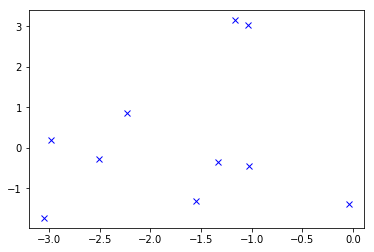

ValueError: x and y must have same first dimension, but have shapes (9724,) and (10,)

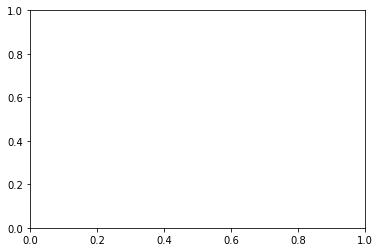

In [54]:
%matplotlib inline 
import pylab as plt # this imports the plotting library in python

print(U.size)
print(V.size)

plt.plot(U[0], U[1], 'bx')
plt.show()

plt.plot(V[0], U[1], 'rx')
plt.show()

## Is Our Map Enough? Are Our Data Enough?

Is two dimensions really enough to capture the complexity of humans and their artforms? Perhaps we need even more dimensions to capture that complexity. Extending our books analogy further, consider how we should place books that have a historical timeframe as well as some geographical location. Do we really want books from the 2nd World War to sit alongside books from the Roman Empire? Books on the American invasion of Sicily in 1943 are perhaps less related to books about Carthage than those that study the Jewish Revolt from 66-70 (in the Roman Province of Judaea). So books that relate to subjects which are closer in time should be stored together. However, a student of rebellion against empire may also be interested in the relationship between the Jewish Revolt of 66-70 and the Indian Rebellion of 1857, nearly 1800 years later. Whilst the technologies are different, the psychology of the people is shared: a rebellious nation angainst their imperial masters, triggered by misrule with a religious and cultural background. To capture such complexities we would need further dimensions in our latent representation. But are further dimensions justified by the amount of data we have? Can we really understand the facets of a film that only has at most three or four ratings?

## Going Further

If you want to take this model further then you'll need more data. You can use again the MovieLens 100k data but increasing the number of users (for example, for the Steepest Descent Algorithm you can do this by modifying the variable `nUsersInExample` that was set as 10 before).

### Question 8

Use stochastic gradient descent to make a movie map for the MovieLens 100k data. Plot the map of the movies when you are finished.

In [55]:
# Code for question 8 here.
ratings = pd.read_csv("./ml-latest-small/ratings.csv") 
Y_full = pd.DataFrame({'users': ratings['userId'], 'movies': ratings['movieId'], 'ratingsorig': ratings['rating']})
Y_full['ratings'] = Y_full['ratingsorig'] - np.mean(Y_full['ratingsorig'])
indexes_unique_users = ratings['userId'].unique()
n_users = indexes_unique_users.shape[0]
indexes_unique_movies = ratings['movieId'].unique()
n_movies = indexes_unique_movies.shape[0]
q = 2
U = pd.DataFrame(np.random.normal(size=(n_users, q))*0.001, index=indexes_unique_users)
V = pd.DataFrame(np.random.normal(size=(n_movies, q))*0.001, index=indexes_unique_movies)

print(U.shape)
print(V.shape)

(610, 2)
(9724, 2)


In [ ]:
iterations = 10
counter = 0
for i in range(iterations):
    # pickup data at random
    idx_list = Y_full.index.values
    np.random.shuffle(idx_list)
    
    for i in idx_list:
        row = Y_full.iloc[i]
        user = row['users']
        film = row['movies']
        rating = row['ratings']
        
        gU, gV = objective_stochastic_gradient(rating, U.loc[user], V.loc[film])
        U.loc[user] -= learn_rate * gU
        V.loc[film] -= learn_rate * gV 
        counter += 1
    
        if counter % 1000 == 0:
            print("Iteration", counter, "Objective function: ", compute_obj(Y_full, U, V))
            
plt.plot(V[0],V[1],'rx')
plt.title('Movie map')
plt.show()

plt.plot(U[0],U[1],'bo')
plt.title('User map')
plt.show()

Iteration 1000 Objective function:  109594.25446404629
Iteration 2000 Objective function:  109594.25439021633
Iteration 3000 Objective function:  109594.25420814751
Iteration 4000 Objective function:  109594.25404968631
Iteration 5000 Objective function:  109594.25389108897
Iteration 6000 Objective function:  109594.25381079156
Iteration 7000 Objective function:  109594.25364209573
Iteration 8000 Objective function:  109594.25346115197
Iteration 9000 Objective function:  109594.25324618384
Iteration 10000 Objective function:  109594.2531769033
Iteration 11000 Objective function:  109594.25299712896
Iteration 12000 Objective function:  109594.25279588107
Iteration 13000 Objective function:  109594.25258686331
Iteration 14000 Objective function:  109594.25246271936
Iteration 15000 Objective function:  109594.25228783731
Iteration 16000 Objective function:  109594.25201253332
Iteration 17000 Objective function:  109594.25187496313
Iteration 18000 Objective function:  109594.25165791574
It